In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_finishers_and_X(df):
    finishers = df[df['stage'] == 21]["rider"].to_list()
    df_finishers = df[df['rider'].isin(finishers)]
    gb = df_finishers.groupby("rider")
    p_dict={}
    g_dict={}
    for rider in finishers:
        p_dict[rider] = np.array(gb.get_group(rider)[['stage','position']].sort_values('stage')['position'])
        g_dict[rider] = np.array(gb.get_group(rider)[['stage','gap']].sort_values('stage')['gap'])

    X_pos = np.array(list(p_dict.values()))
    X_gap = np.array(list(g_dict.values()))
    return (finishers,X_gap,X_pos)

In [4]:
df_giro_19 = pd.read_csv("giro-d-italia_2019.csv")
df_giro_20 = pd.read_csv("giro-d-italia_2020.csv") 
df_giro_21 = pd.read_csv("giro-d-italia_2021.csv")

(finishers,X_gap_19,X_pos_19) = get_finishers_and_X(df_giro_19)
(finishers,X_gap_20,X_pos_20) = get_finishers_and_X(df_giro_20)
(finishers,X_gap_21,X_pos_21) = get_finishers_and_X(df_giro_21)

In [5]:
def evaluate_TSNE(X,title = "",random_state=42):
    from sklearn.manifold import TSNE
    import seaborn as sns
    import warnings
    perplexities = [2,5,10,20,25,30,50]
    n_components = 2

    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()
    plt.suptitle(f"TSNE by perplexity for {title}")
    for _,perplexity in enumerate(perplexities):
        plt.subplot(3,3,_+1)
        plt.title(f"Perplexity: {perplexity}")

        #FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.  warnings.warn(
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tsne = TSNE(n_components = n_components, perplexity = perplexity, random_state=random_state, early_exaggeration = 80, learning_rate=10)
            tsne_result = tsne.fit_transform(X)
        
        df_tsne_result = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
        sns.scatterplot(x='tsne_1', y='tsne_2', data=df_tsne_result,s=120)
        lim = (tsne_result.min()-5, tsne_result.max()+5)

## Evaluation of T-SNE perplexity on time-gap encoding
* NB The axes scales shrink rapidly as perplexity increases
    * With a constant scale the embedding rapidly resembles a tight cluster of data

* Perplexity of 5 is used for subsequent experiments


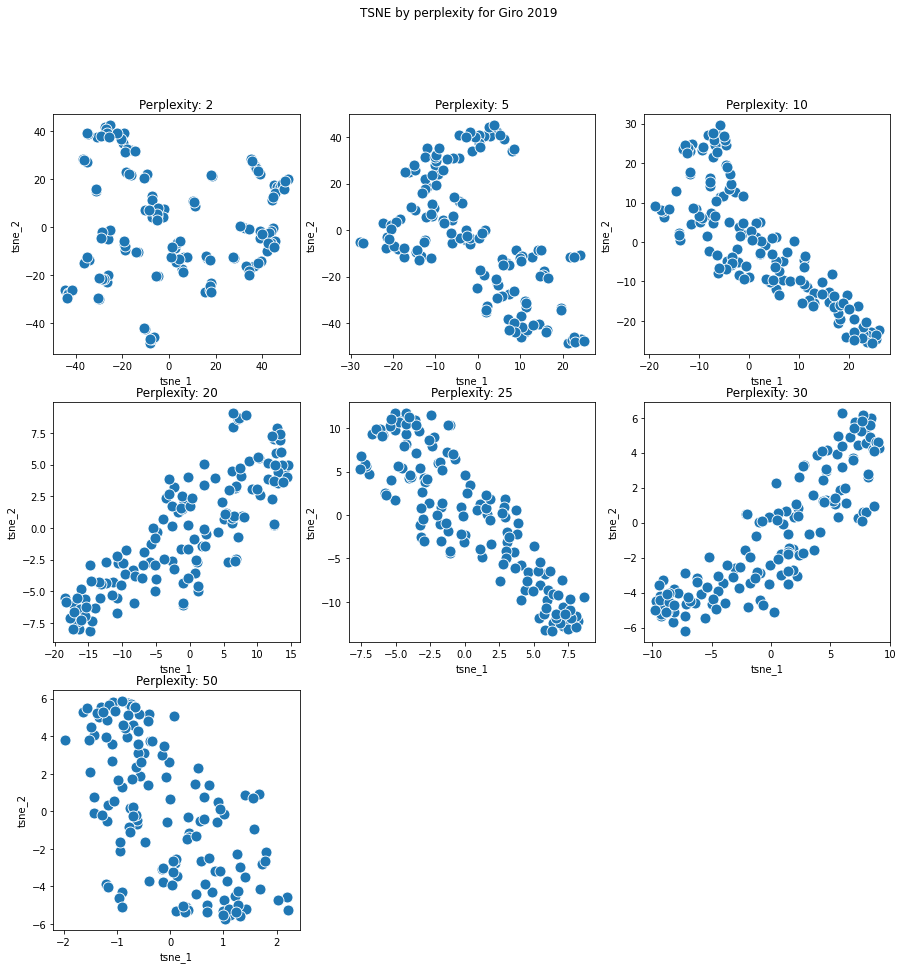

In [6]:
evaluate_TSNE(X_gap_19,"Giro 2019")

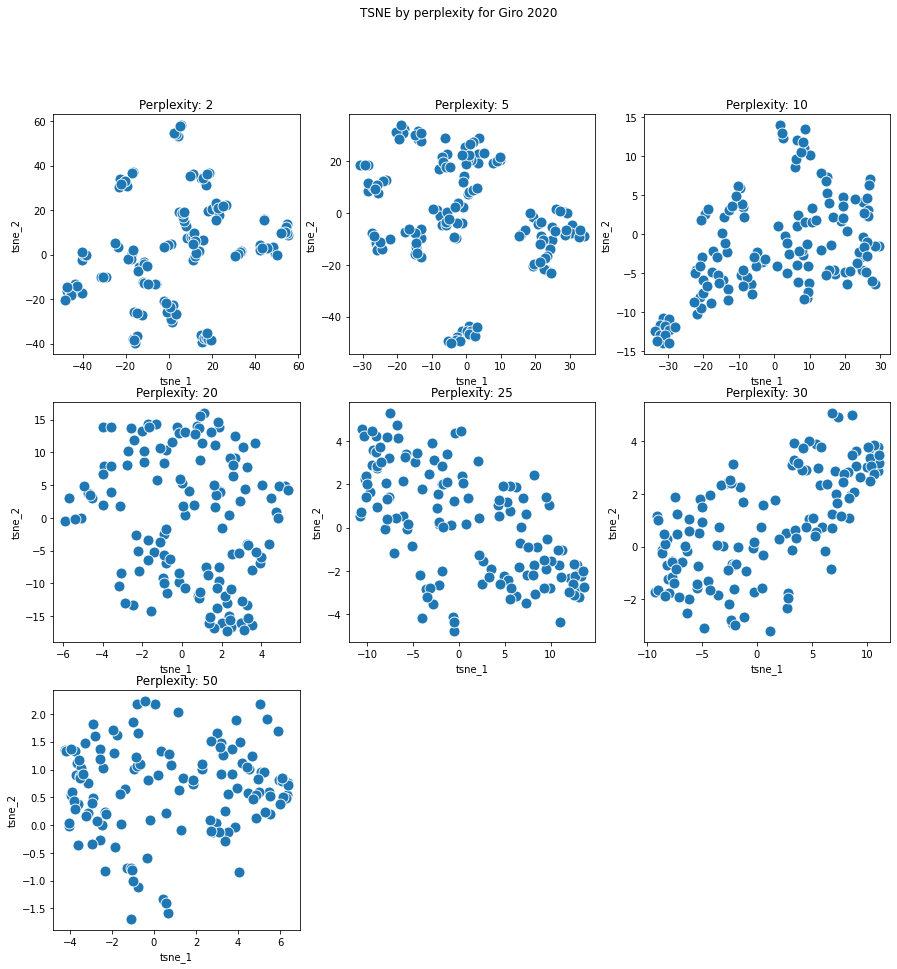

In [7]:
evaluate_TSNE(X_gap_20,"Giro 2020")

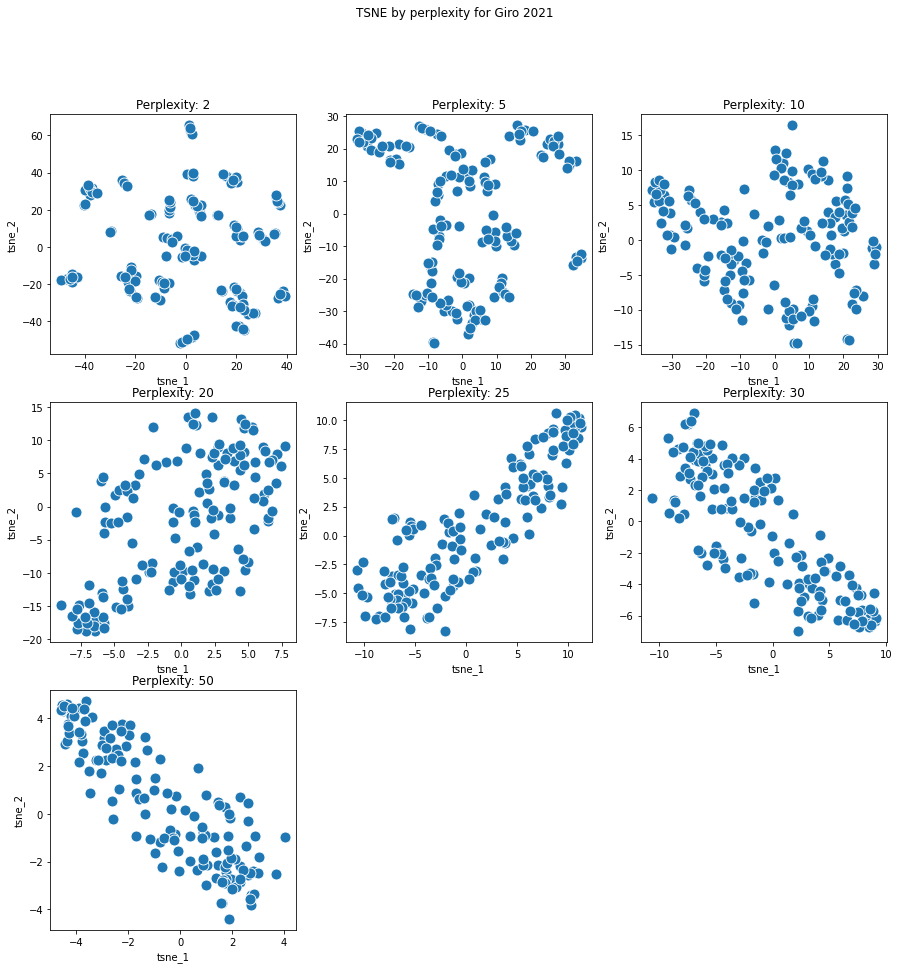

In [8]:
evaluate_TSNE(X_gap_21,"Giro 2021")

In [9]:
def TSNE_fit_plot(X,n_components,perplexity = 5, random_state=42):
    from sklearn.manifold import TSNE
    import seaborn as sns
    tsne = TSNE(n_components = n_components, perplexity = perplexity, random_state=random_state, early_exaggeration = 80, learning_rate=10)
    tsne_result = tsne.fit_transform(X)
    #tsne_result.shape

    df_tsne_result = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', data=df_tsne_result, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    #plt.show()
    return tsne_result

### Clustering the embedded data

A Gaussian Mixture model was used to cluster the embedded data points. This is parameterised by the required number of clusters. The "correct" number of clusters can be determined by eye and/or the use of an information criterion:

In [10]:
def gaussian_and_AIC(visualisation,clusters, title=""):
    from sklearn.mixture import GaussianMixture
    import seaborn as sns
    
    gms = []
    aics=[]
    bics=[]

    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()
    plt.suptitle(f"{title}")

    for _,cluster in enumerate(clusters):
        gm = GaussianMixture(n_components=cluster,n_init=10)
        gm.fit(visualisation)
        gms.append(gm)
        labels = gm.predict(visualisation)
        AIC = gm.aic(visualisation)
        BIC = gm.bic(visualisation)

        aics.append(AIC)
        bics.append(BIC)

        plt.subplot(3,3,_+1)
        plt.title(f"AIC: {AIC:.1f} BIC:{BIC:.1f}")
        df_visualisation = pd.DataFrame({'tsne_1': visualisation[:,0], 'tsne_2': visualisation[:,1]})
        sns.scatterplot(x='tsne_1', y='tsne_2', data=df_visualisation,hue=labels,s=120, palette="tab10")
        #plot_2d_clusters(visualisation,labels)

    #final graph of AIC BIC is space
    if _ < 10:
        plt.subplot(3,3,_+2)
        plt.title("AIC and BIC")

        a = plt.plot(list(range(2,10)),aics,label='AIC')
        b = plt.plot(list(range(2,10)),bics,label='BIC')
        lns=a+b
        labels = [l.get_label() for l in lns]
        plt.legend(lns,labels)
        plt.show()
        
    return ((gms,aics,bics))

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


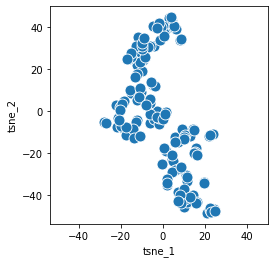

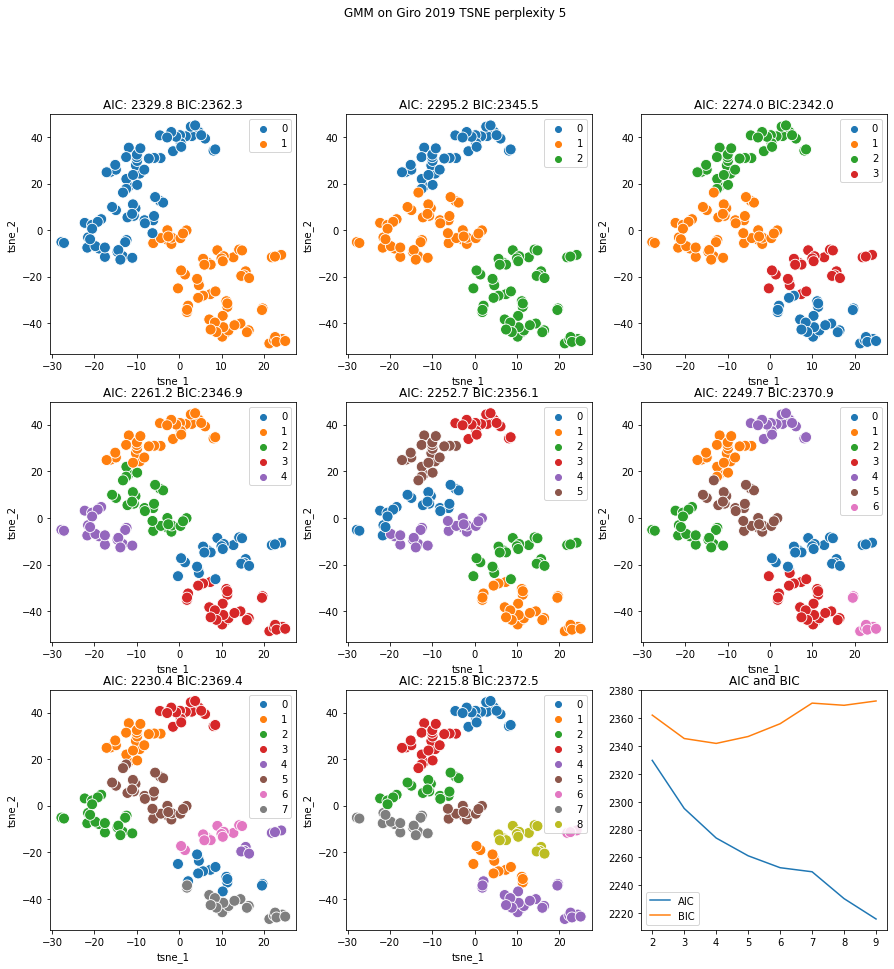

In [11]:
tsne_result_19 = TSNE_fit_plot(X_gap_19,2) #perplexity is 5 by default
(g_19,a_19,b_19) = gaussian_and_AIC(tsne_result_19,range(2,10),"GMM on Giro 2019 TSNE perplexity 5")

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


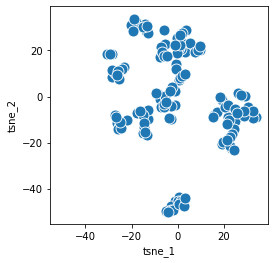

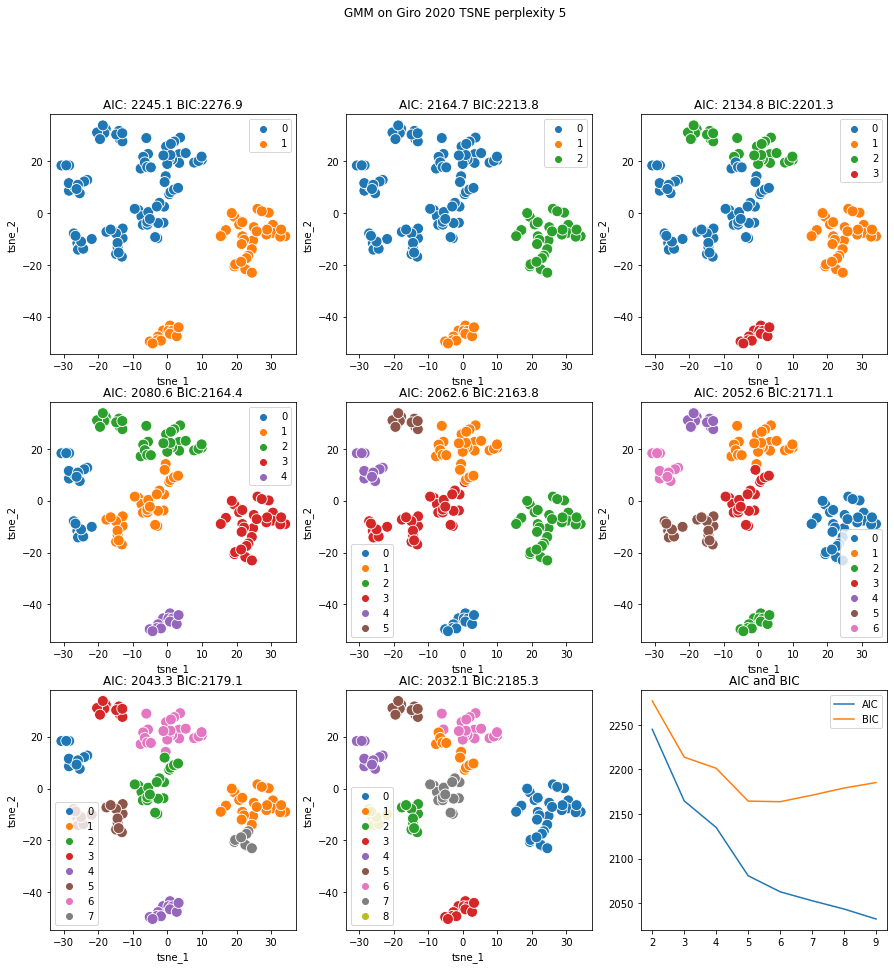

In [12]:
tsne_result_20 = TSNE_fit_plot(X_gap_20,2) #perplexity is 5 by default
(g_20,a_20,b_20) = gaussian_and_AIC(tsne_result_20,range(2,10),"GMM on Giro 2020 TSNE perplexity 5")

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


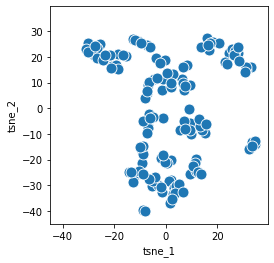

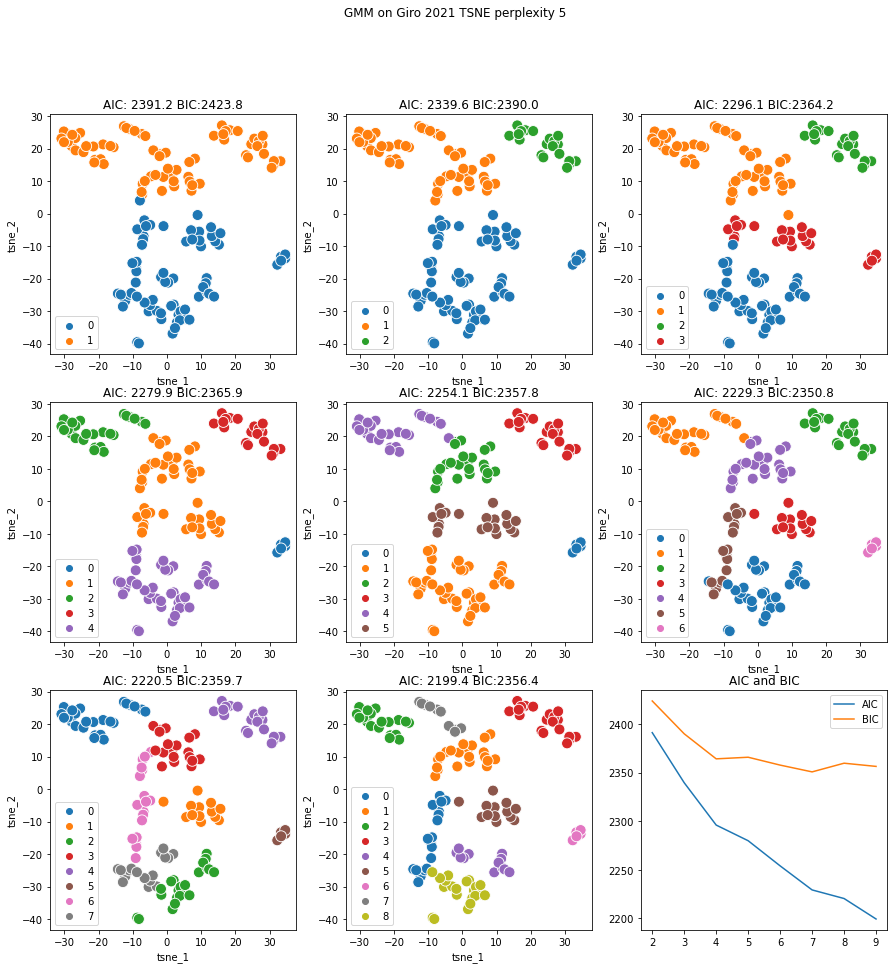

In [13]:
tsne_result_21 = TSNE_fit_plot(X_gap_21,2) #perplexity is 5 by default
(g_21,a_21,b_21) = gaussian_and_AIC(tsne_result_21,range(2,10),"GMM on Giro 2021 TSNE perplexity 5")

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


73 iterations
[0.37 0.01 0.41 0.01 0.01 0.2  0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


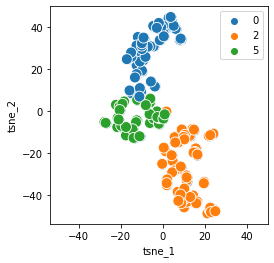

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


21 iterations
[0.27 0.25 0.19 0.09 0.12 0.08 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


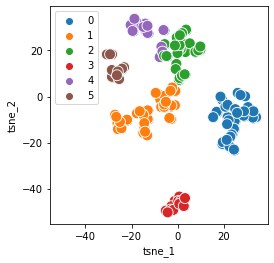

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


68 iterations
[0.34 0.01 0.15 0.17 0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


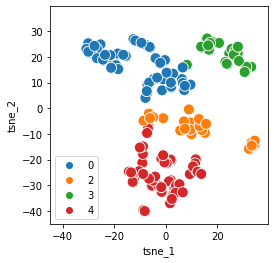

In [14]:
bgm_labels = []
def BGM_cluster(visualisation):
    import seaborn as sns
    from sklearn.mixture import BayesianGaussianMixture
    bgm_t = BayesianGaussianMixture(n_components=20,n_init=10,random_state=42)
    labels = bgm_t.fit_predict (visualisation)
    print(f"{bgm_t.n_iter_} iterations")
    print(np.round(bgm_t.weights_,2))
    df_visualisation = pd.DataFrame({'tsne_1': visualisation[:,0], 'tsne_2': visualisation[:,1]})
    sns.scatterplot(x='tsne_1', y='tsne_2', data=df_visualisation,hue=labels,s=120, palette="tab10")
    plt.show()
    return labels+1

visualisation = TSNE_fit_plot(X_gap_19,2)    
bgm_labels.append(BGM_cluster(visualisation))
visualisation = TSNE_fit_plot(X_gap_20,2)    
bgm_labels.append(BGM_cluster(visualisation))
visualisation = TSNE_fit_plot(X_gap_21,2)    
bgm_labels.append(BGM_cluster(visualisation))


### Tour level clustering

* Process each tour in turn to cluster riders into groups:
    * Extract the time gaps for all riders that finished the whole race (20 or 21 dimensions)
    * Embed the multi-dimensional rider data into 2 dimensions using t-distributed stochastic neighbour embedding (T-SNE)
    * Use Bayesian Gaussian mixture model to cluster the riders into up to 10 groups. The BayesianGaussianMixture object is parameterised with the maximum number of components and infers the most likely number of components removing the need for 



### Inter-tour analysis

#### To Calculate the number of tours where pairs of riders finished in the same group:
* Create a sparse matrix with one row for each rider. The columns represent concatenated one-hot encoding for the groups in each tour
    * (BGM in scikit-learn outputs the original group number so many of the columns will be empty, but since this is a sparse matrix this doesn't matter)
* Multiplying this matrix by its transpose gives a resultant matrix where the rows and columns relate to riders and the numeric values indicate the number of tours in which the pair of riders were in the same group

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


73 iterations
[0.37 0.01 0.41 0.01 0.01 0.2  0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


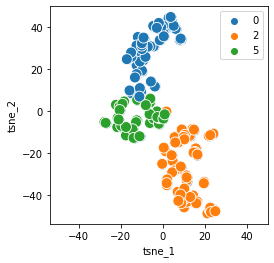

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


21 iterations
[0.27 0.25 0.19 0.09 0.12 0.08 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


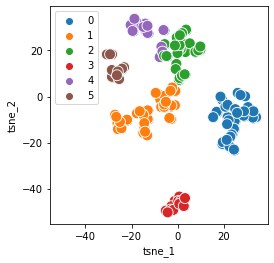

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


68 iterations
[0.34 0.01 0.15 0.17 0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


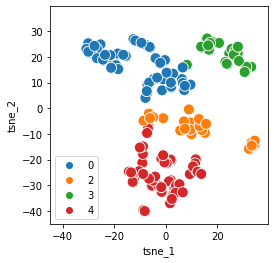

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


57 iterations
[0.65 0.23 0.13 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


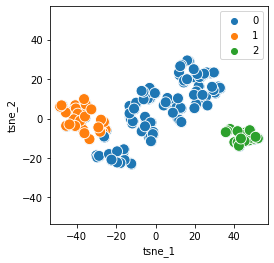

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


51 iterations
[0.21 0.37 0.29 0.13 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


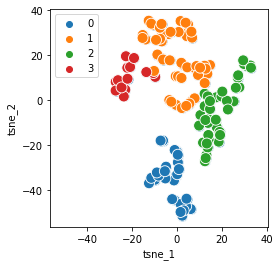

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


21 iterations
[0.01 0.34 0.51 0.01 0.13 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


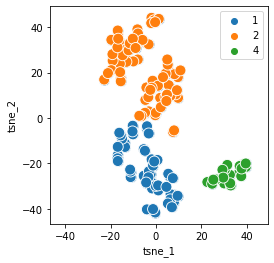

C:\Users\micha\anaconda3\envs\PandasBS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


37 iterations
[0.01 0.48 0.22 0.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]


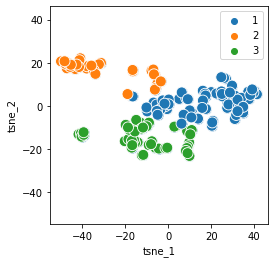

In [15]:
from collections import defaultdict

def get_inputfiles():
    import os
    out = []
    for dirname, _, filenames in os.walk('.'):
        for filename in filenames:
            if str.lower(filename[-4:]) == '.csv' and dirname == '.':
                #print(os.path.join(dirname, filename))
                out.append(filename)

    return out

def get_tour_dfs(files):
    import pandas as pd
    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    return dfs

def get_groups(X,start_col):
    #Input: 
    # X: array of gaps from each stage of a GT 
    # start_col: starting point for the first group in the current tour representing column of a sparse matrix representing appended one-hot encoding for all possible tours

    def BGM_cluster(visualisation):
        import seaborn as sns
        from sklearn.mixture import BayesianGaussianMixture
        #TODO: remove random_state
        bgm_t = BayesianGaussianMixture(n_components=20,n_init=10,random_state=42)
        labels = bgm_t.fit_predict (visualisation)
        print(f"{bgm_t.n_iter_} iterations")
        print(np.round(bgm_t.weights_,2))
        df_visualisation = pd.DataFrame({'tsne_1': visualisation[:,0], 'tsne_2': visualisation[:,1]})
        sns.scatterplot(x='tsne_1', y='tsne_2', data=df_visualisation,hue=labels,s=120, palette="tab10")
        plt.show()
        return labels

    visualisation = TSNE_fit_plot(X,2)    
    bgm_labels = BGM_cluster(visualisation)
    new_start_col = start_col + np.max(bgm_labels)

    return (bgm_labels+start_col,new_start_col)

def get_finishers_and_X(df):
    final_stage = df['stage'].max()
    finishers = df[df['stage'] == final_stage]["rider"].to_list()
    df_finishers = df[df['rider'].isin(finishers)]
    gb = df_finishers.groupby("rider")
    p_dict={}
    g_dict={}
    for rider in finishers:
        p_dict[rider] = np.array(gb.get_group(rider)[['stage','position']].sort_values('stage')['position'])
        g_dict[rider] = np.array(gb.get_group(rider)[['stage','gap']].sort_values('stage')['gap'])

    #print(pos_dict["BODNAR Maciej"])
    #print(gap_dict["BODNAR Maciej"])

    X_pos = np.array(list(p_dict.values()))
    X_gap = np.array(list(g_dict.values()))

    #debug testing
    for _,rider in enumerate(finishers):
        assert X_pos[_].all() == p_dict[rider].all()
        assert X_gap[_].all() == g_dict[rider].all()

    return (finishers,X_gap,X_pos)

def get_finishers_and_groups(df,start_col):
    (finishers,X_gap,X_pos) = get_finishers_and_X(df)
    (groups,new_start_col) = get_groups(X_gap,start_col) # only using gap as position has little relevance in a large bunch finish
    return (finishers,groups,new_start_col)

def process_tours(dfs):
    #Input: array of dataframes containing tour data
    #Output: dictionary of riders and columns
    start_col = 0
    rider_place = defaultdict(set)
    for df in dfs:
        (finishers,groups,new_start_col) = get_finishers_and_groups(df,start_col)
        start_col = new_start_col #starting column for each tour once groups are one-hot encoded
        assert len(groups) == len(finishers)
        for _,group in enumerate(groups):
            rider_place[finishers[_]].add(group)
    return rider_place 

def get_matrix(rider_place):
    from scipy.sparse import csr_matrix
    riders = []
    cols = []
    rows = []
    
    for _,item in enumerate(rider_place.items()):
        (r,groups) = item
        riders.append(r)
        for group in groups:
            rows.append(_)
            cols.append(group)
        data = np.ones(len(rows))

    matrix = csr_matrix((data, (rows, cols)))
    return riders,matrix

data_files = get_inputfiles()
dfs = get_tour_dfs(data_files)
rider_place = process_tours(dfs)
(riders,mat) = get_matrix(rider_place)

### Heat map for similarity between pairs of riders

* These results are for 8 grand tours over 3 years. Few riders will race more than one grand tour per year
* The riders are added in the order in which they are encountered within the data. This explains the tendency for squares to be formed around the diagonal 
    * riders who raced their first grand tour at the same time have a chance to be in the same group, those who didn't race that tour will not have a group in common
* There are a few hot spots away from the diagonal

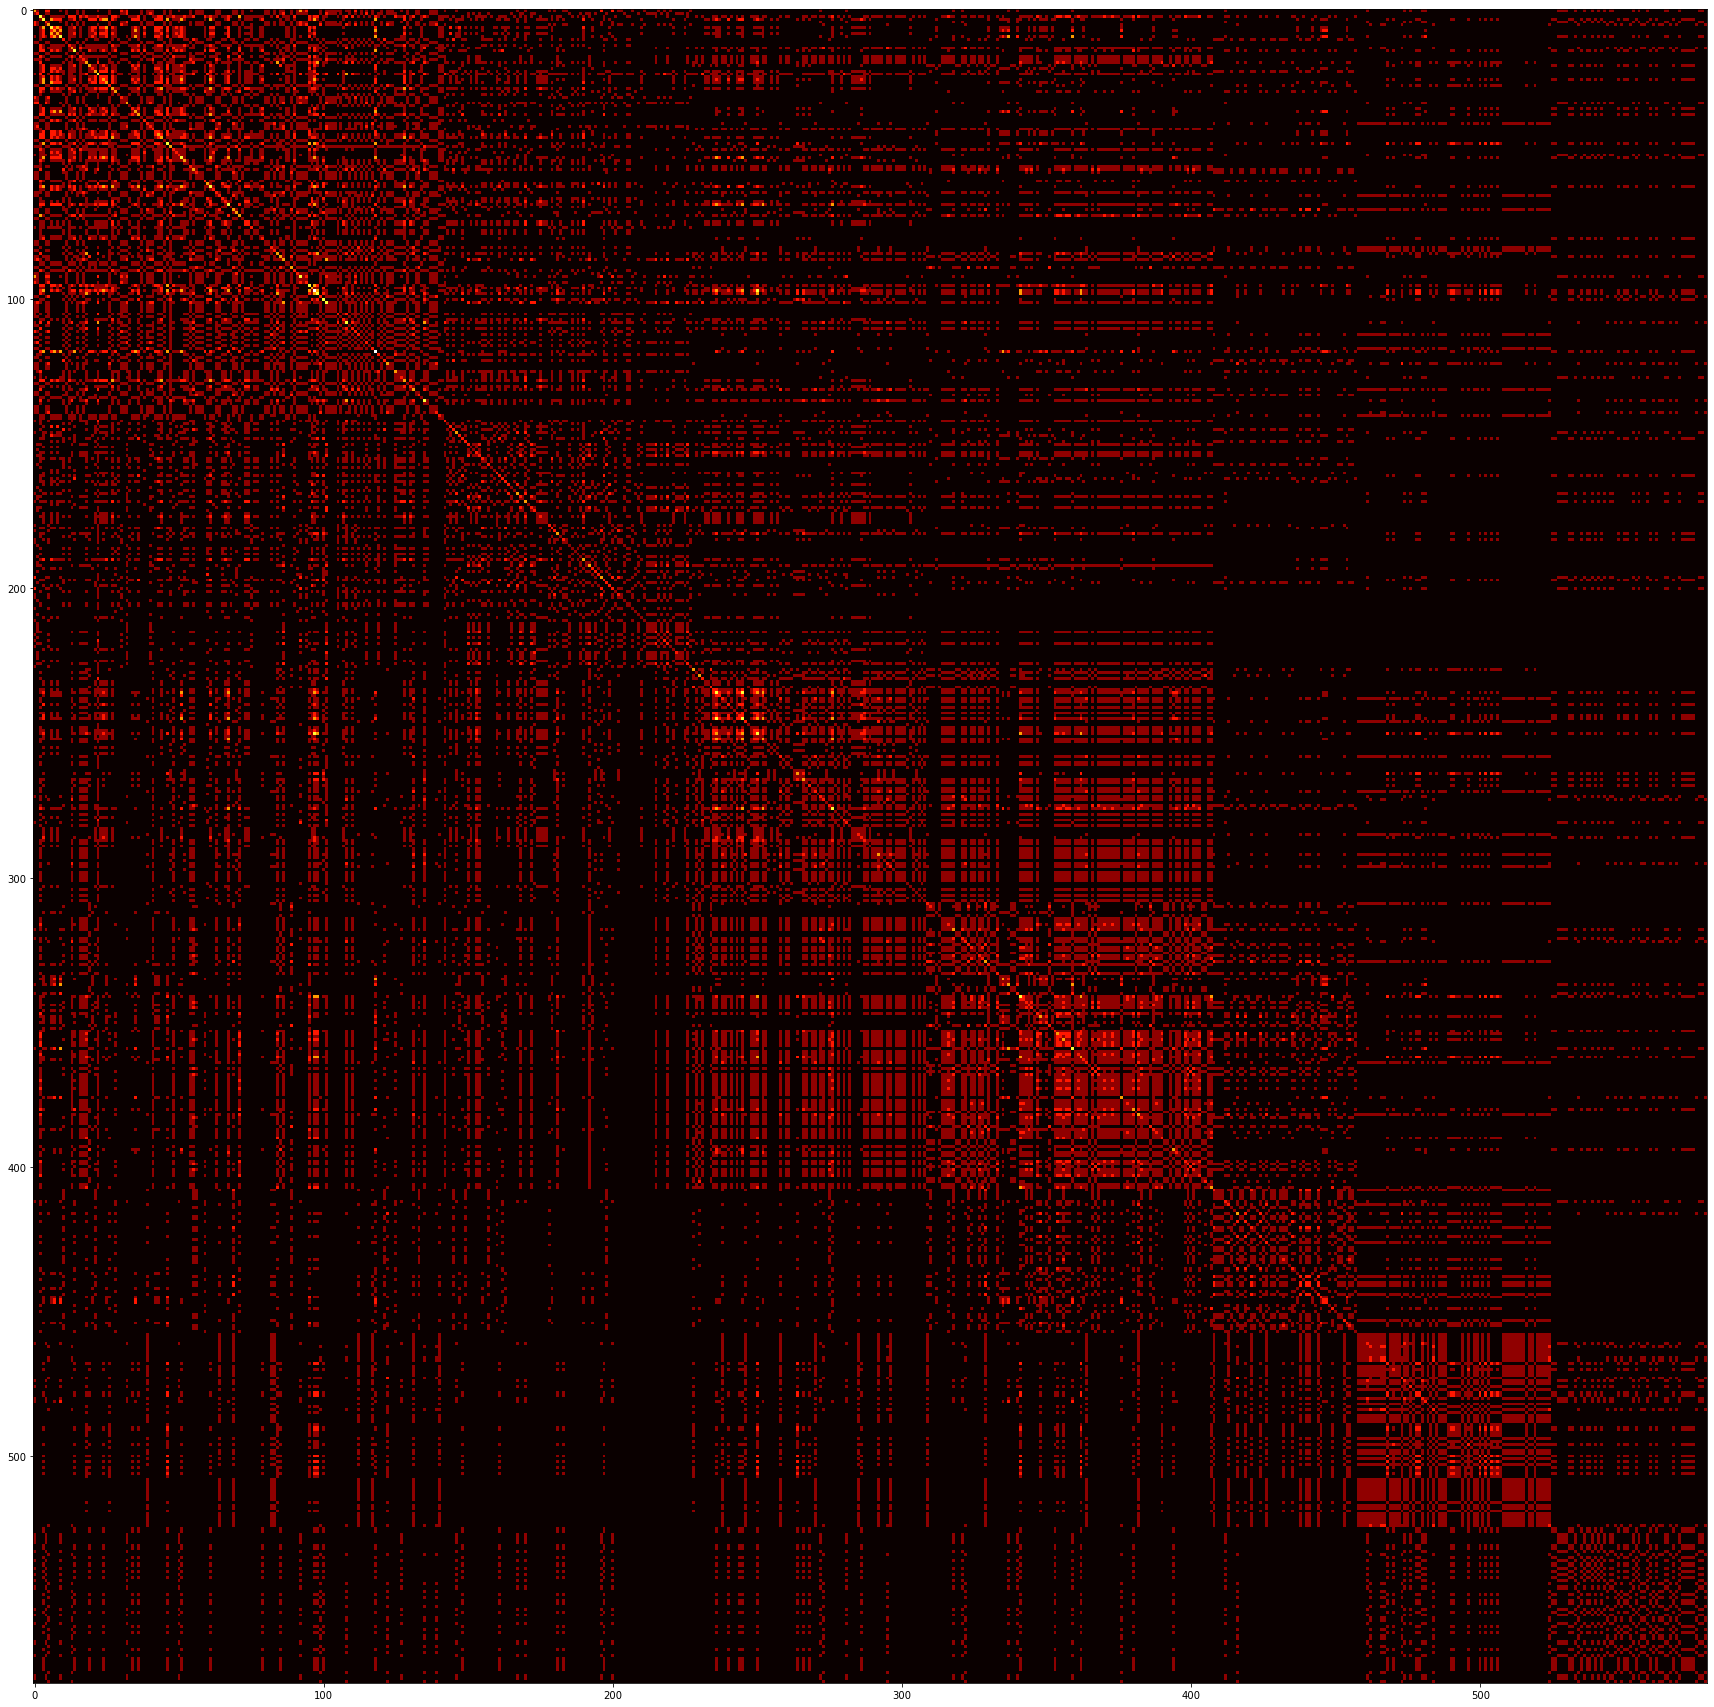

In [16]:
similarity_matrix = np.dot(mat,np.transpose(mat))

#heat plot of similarity
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,40))
plt.imshow(similarity_matrix.toarray(),cmap="hot",interpolation="nearest")
plt.show()

* These results are for 8 grand tours over 3 years. Few riders will race more than one grand tour per year
* The riders are added in the order in which they are encountered within the data. This explains the tendency for squares to be formed around the diagonal 
    * riders who raced their first grand tour at the same time have a chance to be in the same group, those who didn't race that tour will not have a group in common
* There are a few hot spots away from the diagonal

In [17]:
def build_similarity_dictionary(similarity_matrix,riders):
    s_d = {}

    (no_rows,no_cols) = similarity_matrix.shape
    assert no_rows == len(riders)
    for rider in range(no_rows):
        row = similarity_matrix.getrow(rider)
        desc=np.argsort(row.data)[::-1]
        
        similar_riders = []
        for _ in desc:
            sim = row.data[_]

            if sim < 2:
                s_d[riders[rider]] = similar_riders
                break
            else:
                similar_riders.append(row.indices[_])
    return s_d

similarity_dictionary = build_similarity_dictionary(similarity_matrix,riders)

In [18]:
def find_similar(similarity_dictionary,rider):
    print(f"\nriders similar to {rider}:")
    similar = similarity_dictionary[rider]
    out = [([riders[_]],repr(rider_place[riders[_]])) for _ in similar]
    print(f"{out}")

find_similar(similarity_dictionary, "CARAPAZ Richard")
find_similar(similarity_dictionary,'IZAGIRRE Gorka')
find_similar(similarity_dictionary,'MARTIN Dan')
find_similar(similarity_dictionary,'COLBRELLI Sonny')
find_similar(similarity_dictionary,'GANNA Filippo')
find_similar(similarity_dictionary,'SAGAN Peter')
find_similar(similarity_dictionary,'VIVIANI Elia')
find_similar(similarity_dictionary,'KNOX James')


riders similar to CARAPAZ Richard:
[(['CATTANEO Mattia'], '{0, 16, 23}'), (['ROGLIČ Primož'], '{0, 16, 26, 23}'), (['KUSS Sepp'], '{0, 16, 18, 23, 24}'), (['CARAPAZ Richard'], '{0, 16, 23}'), (['IZAGIRRE Ion'], '{0, 16, 20, 24}'), (['HENAO Sergio'], '{16, 23}'), (['NIEVE Mikel'], '{0, 24, 10, 23}'), (['CARTHY Hugh'], '{0, 10, 14, 23}'), (['POELS Wout'], '{16, 26, 23, 15}'), (['MARTIN Guillaume'], '{16, 25, 23}'), (["O'CONNOR Ben"], '{0, 16, 5}'), (['LÓPEZ Miguel Ángel'], '{0, 16}'), (['MAS Enric'], '{16, 26, 23}'), (['VALVERDE Alejandro'], '{16, 18, 23}'), (['MOLLEMA Bauke'], '{0, 16, 10}'), (['GAUDU David'], '{16, 23}'), (['CHAVES Esteban'], '{0, 16, 20, 14}'), (['LANDA Mikel'], '{0, 16}'), (['CARUSO Damiano'], '{0, 16, 10, 24}'), (['BILBAO Pello'], '{0, 8, 10, 16}')]

riders similar to IZAGIRRE Gorka:
[(['GROßSCHARTNER Felix'], '{24, 10, 14, 23}'), (['IZAGIRRE Gorka'], '{24, 10, 14, 23}'), (['CARTHY Hugh'], '{0, 10, 14, 23}'), (['MARTIN Dan'], '{10, 18, 14, 23}'), (['NIEVE Mikel'], 